In [1]:
from google.colab import drive

drive.mount("/content/drive", force_remount=True)
### change `DATA_DIR` to the location where movielens-20m dataset sits
DATA_DIR = '/content/drive/My Drive/Viblo'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!git clone https://github.com/coccoc/coccoc-tokenizer.git 
!pip install cmake
!pip install cython
%cd '/content/coccoc-tokenizer'
!pwd
!mkdir build
%cd build
!cmake -DBUILD_PYTHON=1 '/content/coccoc-tokenizer'
%cd '/content/coccoc-tokenizer/build'
!pwd
!pip install make
!make install
!/content/coccoc-tokenizer/python/build_python.sh setup.py install

from CocCocTokenizer import PyTokenizer

# load_nontone_data is True by default
A = PyTokenizer(load_nontone_data=True)

# tokenize_option:
# 	0: TOKENIZE_NORMAL (default)
#	1: TOKENIZE_HOST
#	2: TOKENIZE_Test
print(A.word_tokenize("xin chào, bạn đã có thể dùng cốc cốc", tokenize_option=0))


Cloning into 'coccoc-tokenizer'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 336 (delta 25), reused 49 (delta 14), pack-reused 266
Receiving objects: 100% (336/336), 55.96 MiB | 11.40 MiB/s, done.
Resolving deltas: 100% (136/136), done.
/content/coccoc-tokenizer
/content/coccoc-tokenizer
/content/coccoc-tokenizer/build
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX com

In [3]:
import numpy as np
!pip install Unidecode
try:
    import re2 as re
except ImportError:
    import re
import numpy as np
from unidecode import unidecode
import os
from collections import Counter
from keras.models import load_model
from numpy import array
from numpy import argmax
from nltk import ngrams
from nltk.translate.bleu_score import sentence_bleu
import string
import math
import pickle

path_checkpoint = '/content/drive/My Drive/VNTones/model'

if (os.path.exists(path_checkpoint)):
    listEpochs = [x for x in os.listdir(path_checkpoint) if x[:6] == 'model_' and x[-3:] == '.h5']
    lastEpoch = max([int(x[-6:-3]) for x in listEpochs])
    lastEpochFile = path_checkpoint + '/' + 'model_%03d.h5' % (lastEpoch)
lastEpochFile = '/content/drive/My Drive/VNTones/model/model_046.h5'

     |████████████████████████████████| 245kB 2.8MB/s 


Using TensorFlow backend.


In [51]:
#############################TRIE AND LEVENHSTEIN########################################################
import pickle
file = open('/content/drive/My Drive/VNTones/dictionary.pkl', 'rb')

# dump information to that file
dict = pickle.load(file)

# close the file
file.close()



MAX_COST = dict
# Keep some interesting statistics
NodeCount = 0
WordCount = 0

# The Trie data structure keeps a set of words, organized with one node for
# each letter. Each node has a branch for each letter that may follow it in the
# set of words.

class TrieNode:
  def find_by_word(self,word):
        """find given *word* in tree, if not occures None is returned"""
        return self.root.find_by_word(word)

class TrieNode:
    def __init__(self):
        self.word = None
        self.children = {}

        global NodeCount
        NodeCount += 1


    def insert( self, word ):
        node = self
        for letter in word:
            if letter not in node.children: 
                node.children[letter] = TrieNode()

            node = node.children[letter]

        node.word = word

# read dictionary file into a trie
trie = TrieNode()
for word in dict:
    WordCount += 1
    trie.insert( word.lower() )

# print("Read %d words into %d nodes") % (WordCount, NodeCount)

# The search function returns a list of all words that are less than the given
# maximum distance from the target word
def Levenshtein_search( word, maxCost ):

    # build first row
    currentRow = range( len(word) + 1 )

    results = []

    # recursively search each branch of the trie
    for letter in trie.children:
        searchRecursive( trie.children[letter], letter, word, currentRow, 
            results, maxCost )

    return results

# This recursive helper is used by the search function above. It assumes that
# the previousRow has been filled in already.
def searchRecursive( node, letter, word, previousRow, results, maxCost ):

    columns = len( word ) + 1
    currentRow = [ previousRow[0] + 1 ]

    # Build one row for the letter, with a column for each letter in the target
    # word, plus one for the empty string at column 0
    for column in range( 1, columns ):

        insertCost = currentRow[column - 1] + 1
        deleteCost = previousRow[column] + 1

        if word[column - 1] != letter:
            replaceCost = previousRow[ column - 1 ] + 1
        else:                
            replaceCost = previousRow[ column - 1 ]

        currentRow.append( min( insertCost, deleteCost, replaceCost ) )

    # if the last entry in the row indicates the optimal cost is less than the
    # maximum cost, and there is a word in this trie node, then add it.
    if currentRow[-1] <= len(maxCost) and node.word != None:
        results.append( (node.word, currentRow[-1] ) )

    # if any entries in the row are less than the maximum cost, then 
    # recursively search each branch of the trie
    if min( currentRow ) <= len(maxCost):
        for letter in node.children:
            searchRecursive( node.children[letter], letter, word, currentRow, 
                results, maxCost )


In [62]:
accented_chars_vietnamese = [
    'á', 'à', 'ả', 'ã', 'ạ', 'â', 'ấ', 'ầ', 'ẩ', 'ẫ', 'ậ', 'ă', 'ắ', 'ằ', 'ẳ', 'ẵ', 'ặ',
    'ó', 'ò', 'ỏ', 'õ', 'ọ', 'ô', 'ố', 'ồ', 'ổ', 'ỗ', 'ộ', 'ơ', 'ớ', 'ờ', 'ở', 'ỡ', 'ợ',
    'é', 'è', 'ẻ', 'ẽ', 'ẹ', 'ê', 'ế', 'ề', 'ể', 'ễ', 'ệ',
    'ú', 'ù', 'ủ', 'ũ', 'ụ', 'ư', 'ứ', 'ừ', 'ử', 'ữ', 'ự',
    'í', 'ì', 'ỉ', 'ĩ', 'ị',
    'ý', 'ỳ', 'ỷ', 'ỹ', 'ỵ',
    'đ',
]
accented_chars_vietnamese.extend([c.upper() for c in accented_chars_vietnamese])
alphabet = list(('\x00 _' + string.ascii_letters + string.digits + ''.join(accented_chars_vietnamese)))
model = load_model(lastEpochFile)
NGRAM = 5
MAXLEN = 30

def remove_accents(input_str):
	s = ''
	for c in input_str:
		if c in s1:
			s += s0[s1.index(c)]
		else:
			s += c
	return s

def sortKey(e):
  	return e[1]

s1 = u'ÀÁÂÃÈÉÊÌÍÒÓÔÕÙÚÝàáâãèéêìíòóôõùúýĂăĐđĨĩŨũƠơƯưẠạẢảẤấẦầẨẩẪẫẬậẮắẰằẲẳẴẵẶặẸẹẺẻẼẽẾếỀềỂểỄễỆệỈỉỊịỌọỎỏỐốỒồỔổỖỗỘộỚớỜờỞởỠỡỢợỤụỦủỨứỪừỬửỮữỰựỲỳỴỵỶỷỸỹ'
s0 = u'AAAAEEEIIOOOOUUYaaaaeeeiioooouuyAaDdIiUuOoUuAaAaAaAaAaAaAaAaAaAaAaAaEeEeEeEeEeEeEeEeIiIiOoOoOoOoOoOoOoOoOoOoOoOoUuUuUuUuUuUuUuYyYyYyYy'
def text_cleaner(text):
    text = re.sub(r"'s\b","",text)
    # remove punctuations
    # INTAB = "ạảãàáâậầấẩẫăắằặẳẵóòọõỏôộổỗồốơờớợởỡéèẻẹẽêếềệểễúùụủũưựữửừứíìịỉĩýỳỷỵỹđẠẢÃÀÁÂẬẦẤẨẪĂẮẰẶẲẴÓÒỌÕỎÔỘỔỖỒỐƠỜỚỢỞỠÉÈẺẸẼÊẾỀỆỂỄÚÙỤỦŨƯỰỮỬỪỨÍÌỊỈĨÝỲỶỴỸĐ"
    text = re.sub("[^a-zA-Z0-9ạảãàáâậầấẩẫăắằặẳẵóòọõỏôộổỗồốơờớợởỡéèẻẹẽêếềệểễúùụủũưựữửừứíìịỉĩýỳỷỵỹđẠẢÃÀÁÂẬẦẤẨẪĂẮẰẶẲẴÓÒỌÕỎÔỘỔỖỒỐƠỜỚỢỞỠÉÈẺẸẼÊẾỀỆỂỄÚÙỤỦŨƯỰỮỬỪỨÍÌỊỈĨÝỲỶỴỸĐ ]", "", text)
    return text

def encode(text, maxlen=MAXLEN):
    text = "\x00" + text
    x = np.zeros((maxlen, len(alphabet)))
    for i, c in enumerate(text[:maxlen]):
        x[i, alphabet.index(c)] = 1
    if i < maxlen-1:
      for j in range(i+1, maxlen):
        x[j, 0] = 1
    return x



def decode(x, calc_argmax=True):
  if calc_argmax:
      x = x.argmax(axis=-1)
  return ''.join(alphabet[i] for i in x)

def extract_phrases(text):
    pattern = r'\w[\w ]*|\s\W+|\W+'
    return re.findall(pattern, text)

def guess(ngram):
    text = ' '.join(ngram)
    preds = model.predict(np.array([encode(text)]), verbose=0)
    # print(decode(preds[0], calc_argmax=True).strip('\x00'))
    return decode(preds[0], calc_argmax=True).strip('\x00')
    
def gen_ngrams(words, n=5):
  if len(words.split())>=5:
    return ngrams(words.split(), n)
  else:
    return ngrams(words.split(), n, pad_left=False, pad_right=True, left_pad_symbol='_', right_pad_symbol='_')

def add_accent(text):
    ngrams = list(gen_ngrams(text, n=NGRAM))
    guessed_ngrams = list(guess(ngram) for ngram in ngrams)
    candidates = [Counter() for _ in range(len(guessed_ngrams) + NGRAM - 1)]
    for nid, ngram in enumerate(guessed_ngrams):
        for wid, word in enumerate(re.split(' +', ngram)):
            candidates[nid + wid].update([word])
    output = ' '.join(c.most_common(1)[0][0] for c in candidates)
    return output

def accent_sentence(sentence):
  list_phrases = extract_phrases(sentence)
  output = ""
  for phrases in list_phrases:
    if len(phrases.split()) < 2 or not re.match("\w[\w ]+", phrases):
      output += phrases
    else:
      phrases = text_cleaner(phrases)
      output += add_accent(phrases)
      if phrases[-1] == " ":
        output += " "
  return output


def token_sentence(kodau,greedy):
  token_kodau=[]
  token_greedy=[]
  token_final=[]
  for i in A.word_tokenize(text_cleaner(kodau.lower()),tokenize_option=0):
      token_kodau.append(i)
  for i in text_cleaner(greedy.lower()).split():
      token_greedy.append(i)
  i=0
  while i < len(token_kodau):
    if(len(token_kodau[i].split("_")) == len(token_greedy[i].split())):
      token_final.append((token_greedy[i]))
      i = i + 1
    else:
      counts = len(token_kodau[i].split("_")) - len(token_greedy[i].split())
      token_final.append(token_greedy[i])
      for count in range(counts):
        token_final[i]+=(' '+token_greedy[i+1])
        del token_greedy[i+1]
      i = i + 1

  return token_final

def collect(data, result_count):
	sequences = [[list(), 0.0]]
	# walk over each step in sequence
	for row in data:
		all_candidates = list()
		# expand each current candidate
		for i in range(len(sequences)):
			seq, score = sequences[i]
			for j in range(len(row)):
				candidate = [seq + [j], score + row[j]]
				all_candidates.append(candidate)
		# order all candidates by score
		ordered = sorted(all_candidates, key=lambda tup:tup[1])
		# select k best
		sequences = ordered[:result_count]
	return sequences

def Mapping(a,b):
  for i in range(len(b)):
    for j in range(len(b[0])):
      b[i][j] = b[i][j]

  for i in range(len(b)):
    for j in range(len(a)):
      b[i][j] = a[j][b[i][j]]
  return b

def summary_result(token_final,result_count=5):
  cand = [[] for i in range(len(token_final))]
  cost = [[] for i in range(len(token_final))]

  for i in range(len(token_final)):
    results = Levenshtein_search( token_final[i], MAX_COST )
    # print(results)
    results.sort(key=sortKey)
    for j in range(len(results[:result_count])):
          cand[i].append(results[j][0])
          cost[i].append(results[j][1])

  # print(cand)
  # print(cost)


  index_cand = collect(cost, result_count)
  candidates_index=[]
  for i in range(len(index_cand)):
      candidates_index.append(index_cand[i][0])
  candidates_index = Mapping(cand,candidates_index)

  return candidates_index
  # print(candidates_index)






In [68]:
text_1 = 'Điều này cũng hoàn toàn phù hợp với xu hướng phát triển của thị trường giai đoạn 3 năm qua khi đã có sự đi lên một cách lành mạnh, chuyên nghiệp và giảm thiểu các nguy cơ rủi ro hơn so với thị trường bất động sản thời kỳ trước'

text_kodau = remove_accents(text_1)

ref = [text_cleaner(text_1).split()]


greedy = (accent_sentence(text_kodau)).replace(" _","")
can = text_cleaner(greedy).split()

score_greedy = sentence_bleu(ref, can, weights=(1,0,0,0))
print('candidate: ',can)
print('reference: ',ref)
print('Output greedy: ',greedy,'===== Điểm BLEU:',score_greedy)
sosanh = token_sentence(text_kodau,greedy)
# print(greedy)
# print(sosanh)
candidates_index = summary_result(sosanh,4)
ref_trie = [text_cleaner(text_1).lower().split()]
for num,i in enumerate(candidates_index):
        result = " ".join(i).replace("_"," ")
        can = result.split()
        score = sentence_bleu(ref_trie, can, weights=(1,0,0,0))
        print('Output ',num + 1,': ',result,'===== Điểm BLEU:',score)

candidate:  ['Điều', 'này', 'cũng', 'hoàn', 'toàn', 'phù', 'hợp', 'với', 'xu', 'hướng', 'phát', 'triển', 'của', 'thị', 'trường', 'giai', 'đoạn', '3', 'năm', 'qua', 'khi', 'đã', 'có', 'sự', 'đi', 'lên', 'một', 'cách', 'lạnh', 'mạnh', 'chuyên', 'nghiệp', 'và', 'giảm', 'thiểu', 'các', 'nguy', 'cơ', 'rủi', 'ro', 'hơn', 'so', 'với', 'thị', 'trường', 'bất', 'động', 'sản', 'thời', 'kỳ', 'trước']
reference:  [['Điều', 'này', 'cũng', 'hoàn', 'toàn', 'phù', 'hợp', 'với', 'xu', 'hướng', 'phát', 'triển', 'của', 'thị', 'trường', 'giai', 'đoạn', '3', 'năm', 'qua', 'khi', 'đã', 'có', 'sự', 'đi', 'lên', 'một', 'cách', 'lành', 'mạnh', 'chuyên', 'nghiệp', 'và', 'giảm', 'thiểu', 'các', 'nguy', 'cơ', 'rủi', 'ro', 'hơn', 'so', 'với', 'thị', 'trường', 'bất', 'động', 'sản', 'thời', 'kỳ', 'trước']]
Output greedy:  Điều này cũng hoàn toàn phù hợp với xu hướng phát triển của thị trường giai đoạn 3 năm qua khi đã có sự đi lên một cách lạnh mạnh, chuyên nghiệp và giảm thiểu các nguy cơ rủi ro hơn so với thị trườn

In [44]:
from tqdm import tqdm
import os
PATH_DATA = "/content/drive/My Drive/VNTones/data_to_draw"
list_file = os.listdir(PATH_DATA)
diagram = [[] for i in range(len(list_file))]
for file in tqdm(list_file):
  score_set=[]
  data_test=[]
  count_lines = 0
  diagram[1].append(file[:-4])
  for line in open(os.path.join(PATH_DATA, file),"r" ):
      print(os.path.join(PATH_DATA, file))
      data_test.append(line)
      count_lines+=1
  for text_1 in data_test:
    # text_1 = text_cleaner(text_1)

    text_kodau = remove_accents(text_1)

    ref = [text_1.split()]

    # print('Input: ',text_kodau)

    greedy = accent_sentence(text_kodau)
    can = greedy.split()

    score_greedy = sentence_bleu(ref, can, weights=(1,0,0,0))
    print('Output greedy: ',greedy,'===== Điểm BLEU:',score_greedy)
  #   sosanh = token_sentence(text_kodau,greedy)
  #   candidates_index = summary_result(sosanh,2)
  #   for num,i in enumerate(candidates_index):
  #       result = " ".join(i).replace("_"," ")
  #       can = result.split()
  #       score = sentence_bleu(ref, can, weights=(1,0,0,0))
  #       print('Output ',num + 1,': ',result,'===== Điểm BLEU:',score)
  #   score_set.append(score_greedy)
  # sum = 0
  # for i in score_set:
  #   sum+=i
  # score_avg = sum/len(score_set)
  # diagram[0].append(score_avg)
print(diagram)


# print('Output greedy: ',greedy,'===== Điểm BLEU:',score_greedy)

# sosanh = token_sentence(text_kodau,greedy)
# candidates_index = summary_result(sosanh,2)



# for num,i in enumerate(candidates_index):
#     result = " ".join(i).replace("_"," ")
#     can = result.split()
#     score = sentence_bleu(ref, can, weights=(1,0,0,0))
#     print('Output ',num + 1,': ',result,'===== Điểm BLEU:',score)
    










  0%|          | 0/5 [00:00<?, ?it/s]

/content/drive/My Drive/VNTones/data_to_draw/500.txt
/content/drive/My Drive/VNTones/data_to_draw/500.txt
/content/drive/My Drive/VNTones/data_to_draw/500.txt
/content/drive/My Drive/VNTones/data_to_draw/500.txt
Output greedy:  "_ _ _ _ Những người khốn khổ _ _ _ _" là tác phẩm nổi tiếng của đại văn hào Victor Hugo xuất bản năm 1962 và trở thành một trong những tác phẩm văn học nổi tiếng nhất thế giới. Những người khốn khổ là câu chuyện về xã hội nước Pháp trong khoảng hơn 20 năm đầu thế kỷ 19 kể từ thời điểm Napoléon I lên ngôi và vài thập niên sau đó. Nhân vật chính của tiểu thuyết là Jean Valjean, một cựu tù khổ sai tìm cách chuộc lại những lỗi lầm gây ra thời trai trẻ nhưng lại không thể thoát khỏi quá khứ của mình. Bản thân Những người khốn khó có rất nhiều câu chuyện, nhân vật với những cuộc đời khác nhau, những sợi dây nối những mảnh đời riêng biệt này lại chính là về Jean Valjean.
 ===== Điểm BLEU: 0.9256756756756757
Output greedy:  Những người khốn khổ là một tác phẩm rất ý ng






 20%|██        | 1/5 [00:16<01:06, 16.67s/it]

Output greedy:  Tác phẩm cũng không hoàn toàn được sáng tác với ý nghĩa hai hước, _ _ _ _ qua tác phẩm _ _ _ _, Cervantes chế giễu những tàn dư của lý tưởng hiệp sĩ phiêu lưu thời phong kiến, đả kích một thị hiếu tầm thường đang phổ biến trong công chúng, hiện lỗ khát khao hướng đến một xã hội hậu phong kiến công bằng và nhân đạo hơn. Một tác phẩm văn chương bất hủ của nhân loại, trường tồn với thời gian, Don Quixote được dịch ra nhiều thứ tiếng nhất trong lịch sử nhân loại chỉ sau "_ _ _ _ Kinh thành _ _ _ _". Tác phẩm đã đưa nhà văn hào kiệt Miguel De Cervantes Saav (1547-1616) đến ánh hào quang của sự nghiệp. Tác phẩm đã được bình chọn là tiểu thuyết hay nhất trong một cuộc điều tra của Viện nghiên cứu Nobel Nauy. Những ý nghĩa nhân văn trong tác phẩm còn sáng mãi một khao khát công bằng, bác ái trong xã hội. ===== Điểm BLEU: 0.8693181818181818
/content/drive/My Drive/VNTones/data_to_draw/700.txt
/content/drive/My Drive/VNTones/data_to_draw/700.txt
/content/drive/My Drive/VNTones/da






 40%|████      | 2/5 [00:36<00:52, 17.57s/it]

Output greedy:  Cuốn tiểu thuyết duy nhất của Emily Bronte là cuốn sách đã tới tay công chúng với nhiều lời bình trái ngược vào năm 1847. Thông qua mối tình giữa Cathy và Heathcliff, với bối cảnh đồng quê Yorkshire hoang vu trong trại, Đội Gió Hủ đã tạo nên cả một thế giới riêng với xu hướng bỏ qua lễ thời, vươn tới thi ca cũng như tới những chiều sâu tăm tối của lòng người, giúp tác phẩm trở thành một trong những tiểu thuyết vĩ đại nhất, bị thương nhất mà con người từng viết ra về nỗi đam mê chạy bỏng. Xuất hiện trên văn đàn thế giới và khẳng định dấu ấn như một hiện tượng độc đáo của văn học cổ điển. Ngoài ra thì cho đến nay, cuốn tiểu thuyết kinh điển của văn học Anh đã được chuyển thể rất nhiều lần lên phim ảnh, _ _ _ _ truyền hình _ _ _ _, _ _ _ _ nhạc kịch và opera _ _ _ _. ===== Điểm BLEU: 0.8505747126436781
/content/drive/My Drive/VNTones/data_to_draw/400.txt
/content/drive/My Drive/VNTones/data_to_draw/400.txt
/content/drive/My Drive/VNTones/data_to_draw/400.txt


IndexError: ignored

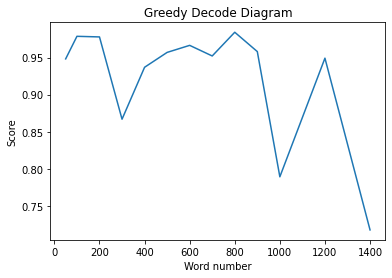

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
diagram = diagram[:2]
# array=[]
# for arr in diagram[:2]:
#   my_arr = (np.array(arr))
#   array.append((my_arr).astype(float))
# print(array)
# plt.plot(array[0],array[1])

# y = diagram[1].astype(float)
# print(y)

plot_data = list(sorted(zip(diagram[0], [int(k) for k in diagram[1]]), key=lambda x: x[1]))
# print(plot_data)
plt.plot([x[1] for x in plot_data], [x[0] for x in plot_data])
plt.title("Greedy Decode Diagram")
plt.xlabel("Word number")
plt.ylabel("Score")
plt.show()